In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
import sklearn
sklearn.set_config(print_changed_only=True)
mpl.rcParams['legend.numpoints'] = 1

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Evaluation Metrics and scoring

### Metrics for binary classification

In [3]:
# import data
from sklearn.model_selection import train_test_split

data = pd.read_csv("data/bank-campaign.csv")
X = data.drop("target", axis=1).values
y = data.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

We'll create a `DummyClassifier` which is just a sklearn module that makes predictions using simple rules - it basically serves as a baseline.

The strategy we'll use is 'most-frequent', which always predicts the most frequent label in the training set.

In [15]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

pred_most_frequent = dummy_majority.predict(X_test)

print("predicted labels: %s" % np.unique(pred_most_frequent))
print("score: %f" % dummy_majority.score(X_test, y_test))

predicted labels: ['no']
score: 0.887540


Next, we train a Decision Tree on the same data set:

In [16]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)

tree.score(X_test, y_test)

0.902787219578518

We also train a Logistic Regression model on the same data set:

In [17]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: %f" % dummy.score(X_test, y_test))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: %f" % logreg.score(X_test, y_test))

dummy score: 0.887540
logreg score: 0.912013


# Confusion matrices

Using sklearn's `confusion_matrix` package

In [18]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print(confusion)

[[8911  228]
 [ 678  480]]


In [19]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[9139    0]
 [1158    0]]

Dummy model:
[[9139    0]
 [1158    0]]

Decision tree:
[[8809  330]
 [ 671  487]]

Logistic Regression
[[8911  228]
 [ 678  480]]


In [20]:
from sklearn.metrics import f1_score

print("f1 score most frequent: %.2f" % f1_score(y_test, pred_most_frequent, pos_label="yes"))
print("f1 score dummy: %.2f" % f1_score(y_test, pred_dummy, pos_label="yes"))
print("f1 score tree: %.2f" % f1_score(y_test, pred_tree, pos_label="yes"))
print("f1 score logreg: %.2f" % f1_score(y_test, pred_logreg, pos_label="yes"))

f1 score most frequent: 0.00
f1 score dummy: 0.00
f1 score tree: 0.49
f1 score logreg: 0.51


C:\Users\jfields\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_most_frequent,
                            target_names=["no", "yes"]))

              precision    recall  f1-score   support

          no       0.89      1.00      0.94      9139
         yes       0.00      0.00      0.00      1158

    accuracy                           0.89     10297
   macro avg       0.44      0.50      0.47     10297
weighted avg       0.79      0.89      0.83     10297



C:\Users\jfields\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
print(classification_report(y_test, pred_tree,
                            target_names=["no", "yes"]))

              precision    recall  f1-score   support

          no       0.93      0.96      0.95      9139
         yes       0.60      0.42      0.49      1158

    accuracy                           0.90     10297
   macro avg       0.76      0.69      0.72     10297
weighted avg       0.89      0.90      0.90     10297



In [23]:
print(classification_report(y_test, pred_logreg,
                            target_names=["no", "yes"]))

              precision    recall  f1-score   support

          no       0.93      0.98      0.95      9139
         yes       0.68      0.41      0.51      1158

    accuracy                           0.91     10297
   macro avg       0.80      0.69      0.73     10297
weighted avg       0.90      0.91      0.90     10297



# Taking uncertainty into account

## Precision-Recall curves and ROC curves

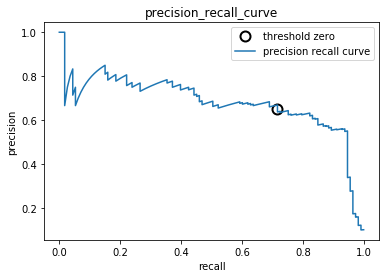

In [24]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve


# create a similar dataset as before, but with more samples to get a smoother curve
X, y = make_blobs(n_samples=8000, centers=2, cluster_std=[7.0, 2], random_state=22, shuffle=False)
X, y = X[:4500], y[:4500]

# build an imbalanced synthetic dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))

# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.figure()
plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(recall, precision, label="precision recall curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision_recall_curve");
plt.legend(loc="best")

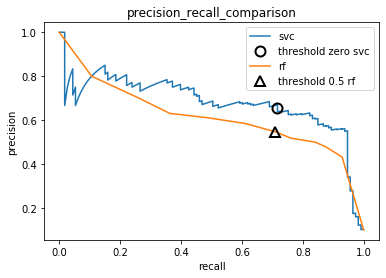

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba, but not decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])
plt.figure()

plt.plot(recall, precision, label="svc")

plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(recall_rf, precision_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(recall_rf[close_default_rf], precision_rf[close_default_rf], '^', markersize=10,
         label="threshold 0.5 rf", fillstyle="none", c='k', mew=2)
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision_recall_comparison");

In [26]:
print("f1_score of random forest: %f" % f1_score(y_test, rf.predict(X_test)))
print("f1_score of svc: %f" % f1_score(y_test, svc.predict(X_test)))

f1_score of random forest: 0.597403
f1_score of svc: 0.683544


In [27]:
from sklearn.metrics import average_precision_score

ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print("average precision of random forest: %f" % ap_rf)
print("average precision of svc: %f" % ap_svc)

average precision of random forest: 0.573306
average precision of svc: 0.682160


# Receiver Operating Characteristics (ROC) and AUC
\begin{equation}
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
\end{equation}

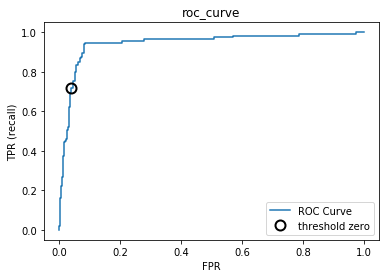

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.figure()

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("roc_curve");

# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

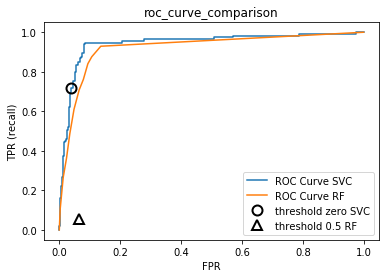

In [31]:
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("roc_curve_comparison");
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4);

In [32]:
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print("AUC for Random Forest: %f" % rf_auc)
print("AUC for SVC: %f" % svc_auc)

AUC for Random Forest: 0.921574
AUC for SVC: 0.944244


## Using evaluation metrics in model selection

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# default scoring for classification is accuracy
print("default scoring ",
      cross_val_score(LogisticRegression(), cancer.data, cancer.target))

# providing scoring="accuracy" doesn't change the results
explicit_accuracy =  cross_val_score(LogisticRegression(), cancer.data, cancer.target,
                                     scoring="accuracy")
print("explicit accuracy scoring ", explicit_accuracy)

ap =  cross_val_score(LogisticRegression(), cancer.data, cancer.target,
                           scoring="average_precision")
print("average precision", ap)

default scoring  [0.93684211 0.96842105 0.94179894]
explicit accuracy scoring  [0.93684211 0.96842105 0.94179894]
average precision [0.99540632 0.99852553 0.99109504]


In [34]:
from sklearn.model_selection import cross_validate

res = cross_validate(SVC(), cancer.data, cancer.target,
                     scoring=["accuracy", "average_precision", "recall_macro"],
                     return_train_score=True)

display(pd.DataFrame(res))

,fit_time,score_time,test_accuracy,train_accuracy,test_average_precision,train_average_precision,test_recall_macro,train_recall_macro
0,0.014992,0.017920,0.626316,1.0,0.962843,1.0,0.5,1.0
1,0.013964,0.016953,0.626316,1.0,0.957514,1.0,0.5,1.0
2,0.012965,0.016954,0.629630,1.0,0.969766,1.0,0.5,1.0


In [35]:
from sklearn.metrics.scorer import SCORERS

print(sorted(SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'brier_score_loss', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']


In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
data = pd.read_csv("data/bank-campaign.csv")

# back to the bank campaign
X = data.drop("target", axis=1).values
y = data.target.values == "no"


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=.1, test_size=.1, random_state=0)

param_grid = {'C': [0.0001, 0.01, 0.1, 1, 10]}

# using AUC scoring instead:
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid,
                    scoring=["roc_auc", 'average_precision', 'accuracy'],
                    refit='roc_auc')
grid.fit(X_train, y_train)

print("Grid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC):", grid.best_score_)
print("Test set AUC: %.3f" % grid.score(X_test, y_test))

Grid-Search with AUC
Best parameters: {'C': 0.1}
Best cross-validation score (AUC): 0.9369391799261461
Test set AUC: 0.935


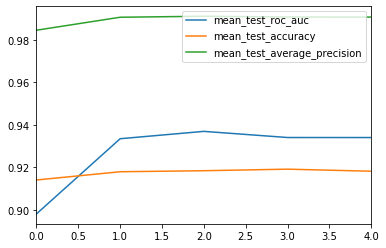

In [53]:
res = pd.DataFrame(grid.cv_results_)
res[['mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_average_precision']].plot();

# Exercise
Load the adult dataset from ``data/adult.csv`` (or pick another dataset), and split it into training and test set.
Apply grid-search to the training set, searching for the best C for Logistic Regression using AUC.
Plot the ROC curve and precision-recall curve of the best model on the test set.

In [41]:
# import data
import pandas as pd
data = pd.read_csv("data/bank-campaign.csv")
display(data.head())

y = data.target
X = data.drop("target", axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,target
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,no
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,no
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,no
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,no
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,no


In [54]:
param_grid = {'C': [0.0001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid=param_grid,
                    scoring='roc_auc', refit='roc_auc', cv=10)

grid.fit(X_train, y_train)

print("Grid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC):", grid.best_score_)
print("Test set AUC: %.3f" % grid.score(X_test, y_test))

Grid-Search with AUC
Best parameters: {'C': 0.1}
Best cross-validation score (AUC): 0.9379287917238773
Test set AUC: 0.935


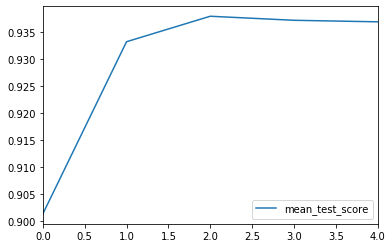

In [56]:
res = pd.DataFrame(grid.cv_results_)
res[['mean_test_score']].plot();

Plotting the precision/recall curves

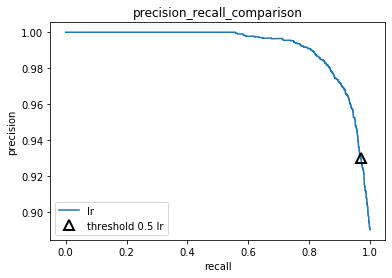

In [58]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(
    y_test, grid.predict_proba(X_test)[:, 1])

plt.figure()

plt.plot(recall_lr, precision_lr, label="lr")

close_default_lr = np.argmin(np.abs(thresholds_lr - 0.5))
plt.plot(recall_lr[close_default_lr], precision_lr[close_default_lr], '^', markersize=10,
         label="threshold 0.5 lr", fillstyle="none", c='k', mew=2)
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision_recall_comparison");

Plotting the ROC curve

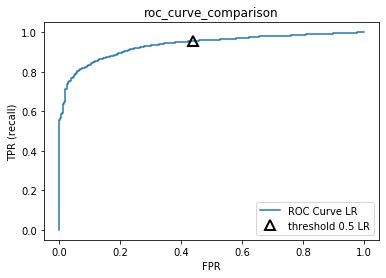

In [60]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, grid.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr_lr, tpr_lr, label="ROC Curve LR")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("roc_curve_comparison");

close_default_rf = np.argmin(np.abs(thresholds_lr - 0.5))

plt.plot(fpr_lr[close_default_lr], tpr_lr[close_default_lr], '^', markersize=10,
         label="threshold 0.5 LR", fillstyle="none", c='k', mew=2)

plt.legend(loc=4);